In [1]:
import os, sys, json, time, warnings
from pathlib import Path
import numpy as np
import pandas as pd
from tqdm.auto import tqdm

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

In [2]:
# Paths (adjust if your layout differs)
ROOT = Path('/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit')
DATA = ROOT / "data"
SRC  = ROOT / "src"
SUBM = ROOT / "sample_submission"

# Ensure src is importable
if str(SRC) not in sys.path:
    sys.path.insert(0, str(SRC))

# Create sample_submission dir if missing
SUBM.mkdir(parents=True, exist_ok=True)

SEED = 1337
np.random.seed(SEED)
torch.manual_seed(SEED)

DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE

'cuda'

In [3]:
# Load dataset files
info_path = DATA / "dataset_info.json"
if info_path.exists():
    info = json.loads(info_path.read_text(encoding="utf-8"))
    print("dataset_info.json loaded. Keys:", list(info.keys()))
    print(json.dumps({k: info[k] for k in ['features','input_len','horizon_len','outputs']}, indent=2))
else:
    print("dataset_info.json not found at", info_path)

# Peek train / x_test
train_path = DATA / "train.pkl"
x_test_path  = DATA / "x_test.pkl"
y_local_path = DATA / "y_test_local.pkl"

train = pd.read_pickle(train_path)
x_test  = pd.read_pickle(x_test_path)
y_test_local = pd.read_pickle(y_local_path)

print("train shape:", train.shape, "| columns:", train.columns.tolist())
print("x_test  shape:", x_test.shape,  "| columns:", x_test.columns.tolist())
print("y_test_local shape:", y_test_local.shape, "| columns:", y_test_local.columns.tolist())

display(train.head(3))
display(x_test.head(3))
display(y_test_local.head(3))

dataset_info.json loaded. Keys: ['freq', 'features', 'input_len', 'horizon_len', 'dtypes', 'outputs', 'sha256']
{
  "features": [
    "close",
    "volume"
  ],
  "input_len": 60,
  "horizon_len": 10,
  "outputs": {
    "train": {
      "columns": [
        "series_id",
        "time_step",
        "close",
        "volume"
      ]
    },
    "x_test": {
      "columns": [
        "window_id",
        "time_step",
        "close",
        "volume"
      ]
    },
    "y_test_local": {
      "columns": [
        "window_id",
        "time_step",
        "close"
      ]
    }
  }
}
train shape: (18331224, 4) | columns: ['series_id', 'time_step', 'close', 'volume']
x_test  shape: (3000000, 4) | columns: ['window_id', 'time_step', 'close', 'volume']
y_test_local shape: (20, 3) | columns: ['window_id', 'time_step', 'close']


,series_id,time_step,close,volume
0,1,0,0.13700,171985.703125
1,1,1,0.13656,85451.398438
2,1,2,0.13647,121151.898438


,window_id,time_step,close,volume
0,1,0,0.1126,24976.0
1,1,1,0.1126,0.0
2,1,2,0.1125,2299.0


,window_id,time_step,close
0,1,0,0.1131
1,1,1,0.1131
2,1,2,0.1130


In [50]:
dummy = train[train['series_id']==9]['close'].copy(deep=True)

np.log(dummy).diff(60).corr(np.log(dummy).diff(10).shift(-10))

np.float64(-0.020102396439824016)

In [4]:
# Use the sampler logic from src/dataset.py to slice windows
from icaif.dataset import TrainWindowSampler

class WindowsDataset(Dataset):
    """
    Wrap TrainWindowSampler into a PyTorch Dataset.
    Returns:
      X: (60, 2) float32 -> [close, volume]
      y: (10,)  float32 -> future close
    """
    def __init__(self, train_path: str, rolling: bool = True, step_size: int = 1, max_samples: int = None):
        self.sampler = TrainWindowSampler(
            train_path=train_path,
            window=70,
            input_len=60,
            horizon_len=10,
            rolling=rolling,
            step_size=step_size,
            seed=SEED,
        )
        # Materialize (optionally capped) for stable batching
        xs, ys = [], []
        for i, (X, y) in enumerate(self.sampler.iter_windows()):
            xs.append(X.astype(np.float32))
            ys.append(y.astype(np.float32))
            if max_samples is not None and (i + 1) >= max_samples:
                break
        self.X = np.stack(xs, axis=0) if xs else np.zeros((0,60,2), dtype=np.float32)
        self.y = np.stack(ys, axis=0) if ys else np.zeros((0,10), dtype=np.float32)

    def __len__(self):  return len(self.X)
    def __getitem__(self, i):
        return torch.from_numpy(self.X[i]), torch.from_numpy(self.y[i])

# For a quick demo, cap samples. Increase for better quality.
MAX_SAMPLES = 100_000  # set to None to use all windows
train_ds = WindowsDataset(str(train_path), rolling=True, step_size=1, max_samples=MAX_SAMPLES)
len(train_ds), train_ds.X.shape, train_ds.y.shape

(100000, (100000, 60, 2), (100000, 10))

## Features

In [5]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader


In [6]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader

# ----------------------------
# Utilities
# ----------------------------

def sinusoidal_position_encoding(n_positions: int, d_model: int, device: torch.device) -> torch.Tensor:
    """Return shape: (1, n_positions, d_model)."""
    position = torch.arange(n_positions, dtype=torch.float32, device=device).unsqueeze(1)  # (n,1)
    div_term = torch.exp(
        torch.arange(0, d_model, 2, dtype=torch.float32, device=device) * (-np.log(10000.0) / d_model)
    )
    pe = torch.zeros(n_positions, d_model, device=device)
    pe[:, 0::2] = torch.sin(position * div_term)
    pe[:, 1::2] = torch.cos(position * div_term)
    return pe.unsqueeze(0)  # (1,n_positions,d_model)


# ----------------------------
# Feature engineering
# ----------------------------

class FeatureBuilder:
    """
    Build features from a (B,60,2) window of [price, volume] and targets from a (B,H) future price path.

    Time features (B,60,3):
        - r_hat: standardized log-returns (σ per-sample over last 59 returns), padded with 0 at t=0
        - v_z: volume z-score within window
        - Δv_z: first-difference of v_z, padded with 0 at t=0

    Static features (B,F):
        - shock density (|v_z|>2), corr(r_hat,v_z), ACF lags 1..3 of r_hat,
          short momentums (3/5/10), top-K rFFT magnitudes (ex-DC),
          skewness, excess kurtosis, and a robust MAD-like scale of r_hat.

    Targets:
        - future normalized log-returns relative to final in-window log-price, divided by σ
    """
    def __init__(self, eps: float = 1e-8, fft_k: int = 4):
        self.eps = float(eps)
        self.fft_k = int(fft_k)

    def _safe_log(self, x: np.ndarray) -> np.ndarray:
        return np.log(np.clip(x, self.eps, None))

    def build_time_features(self, X_batch: np.ndarray):
        # X_batch: (B,60,2) -> time features (B,60,3): [r_hat, v_z, dv_z]
        B = X_batch.shape[0]
        price = X_batch[..., 0].astype(np.float32)
        vol = X_batch[..., 1].astype(np.float32)

        # Log-returns with 0 padding at t=0 to keep length 60
        lp = self._safe_log(price)
        r = lp[:, 1:] - lp[:, :-1]                                              # (B,59)
        r_pad = np.concatenate([np.zeros((B, 1), dtype=np.float32), r], axis=1) # (B,60)

        # Per-sample volatility over the 59 non-padded returns
        sigma = np.sqrt(np.mean(r**2, axis=1, keepdims=True) + self.eps).astype(np.float32)  # (B,1)
        r_hat = r_pad / (sigma + self.eps)  # (B,60)

        # Volume z-score within the 60-min window
        v_mean = vol.mean(axis=1, keepdims=True)
        v_std = vol.std(axis=1, keepdims=True) + self.eps
        v_z = (vol - v_mean) / v_std  # (B,60)

        # Δv_z with 0 padding at t=0
        dv = np.concatenate(
            [np.zeros((B, 1), dtype=np.float32), v_z[:, 1:] - v_z[:, :-1]],
            axis=1
        )  # (B,60)

        time_feats = np.stack([r_hat, v_z, dv], axis=-1).astype(np.float32)  # (B,60,3)
        last_log_price = lp[:, -1:].astype(np.float32)  # (B,1)
        return time_feats, sigma.astype(np.float32), last_log_price

    def build_static_features(self, r_hat: np.ndarray, v_z: np.ndarray) -> np.ndarray:
        # r_hat, v_z: (B,60)
        eps = self.eps

        # Shock density on volume
        shock_density = (np.abs(v_z) > 2.0).mean(axis=1, keepdims=True).astype(np.float32)  # (B,1)

        # Corr(r_hat, v_z)
        rh_mu = r_hat.mean(axis=1, keepdims=True)
        vz_mu = v_z.mean(axis=1, keepdims=True)
        rh_c = r_hat - rh_mu
        vz_c = v_z - vz_mu
        cov = np.mean(rh_c * vz_c, axis=1, keepdims=True)
        var_rh = np.mean(rh_c**2, axis=1, keepdims=True) + eps
        var_vz = np.mean(vz_c**2, axis=1, keepdims=True) + eps
        corr_r_v = (cov / np.sqrt(var_rh * var_vz)).astype(np.float32)  # (B,1)

        # ACF at lags 1..3
        def acf_lag(x, lag: int):
            x1 = x[:, lag:]
            x2 = x[:, :-lag]
            mu1 = x1.mean(axis=1, keepdims=True)
            mu2 = x2.mean(axis=1, keepdims=True)
            num = np.mean((x1 - mu1) * (x2 - mu2), axis=1, keepdims=True)
            den = np.sqrt(
                np.mean((x1 - mu1) ** 2, axis=1, keepdims=True) *
                np.mean((x2 - mu2) ** 2, axis=1, keepdims=True) + eps
            )
            return (num / (den + eps)).astype(np.float32)  # (B,1)

        acf1 = acf_lag(r_hat, 1)
        acf2 = acf_lag(r_hat, 2)
        acf3 = acf_lag(r_hat, 3)

        # Short momentum over last k steps (sum of normalized returns)
        def tail_sum(x, k: int):
            return np.sum(x[:, -k:], axis=1, keepdims=True).astype(np.float32)

        mom3  = tail_sum(r_hat, 3)
        mom5  = tail_sum(r_hat, 5)
        mom10 = tail_sum(r_hat, 10)

        # FFT magnitudes (exclude DC), normalize by non-DC energy, take first K bins
        R = np.fft.rfft(r_hat, axis=1)   # (B, 60//2+1)
        mags = np.abs(R).astype(np.float32)  # includes DC at index 0
        non_dc = mags[:, 1:]  # (B, Freq-1)
        denom = non_dc.sum(axis=1, keepdims=True) + eps
        mags_norm_non_dc = non_dc / denom  # (B, Freq-1)
        K = min(self.fft_k, mags_norm_non_dc.shape[1])
        fft_feats = mags_norm_non_dc[:, :K]  # (B, K)

        # Global stats on r_hat (remove mean)
        r_mu = r_hat.mean(axis=1, keepdims=True)
        r_c = r_hat - r_mu
        var = np.mean(r_c**2, axis=1, keepdims=True) + eps
        skew = (np.mean(r_c**3, axis=1, keepdims=True) / (np.power(var, 1.5) + eps)).astype(np.float32)
        kurt_excess = (np.mean(r_c**4, axis=1, keepdims=True) / (var**2 + eps) - 3.0).astype(np.float32)

        # Robust scale via MAD-like measure
        mad = np.median(np.abs(r_hat - np.median(r_hat, axis=1, keepdims=True)),
                        axis=1, keepdims=True).astype(np.float32)

        static_feats = np.concatenate([
            skew, kurt_excess, corr_r_v, shock_density,
            acf1, acf2, acf3,
            mom3, mom5, mom10,
            fft_feats, mad
        ], axis=1).astype(np.float32)
        return static_feats  # shape (B, F)

    def transform_batch(self, X_batch: np.ndarray, y_prices_batch: np.ndarray):
        # X_batch: (B,60,2), y_prices_batch: (B,H)
        time_feats, sigma, last_log_price = self.build_time_features(X_batch)
        r_hat = time_feats[..., 0]  # (B,60)
        v_z   = time_feats[..., 1]  # (B,60)

        static_feats = self.build_static_features(r_hat, v_z)  # (B,F)

        # Build targets: per-step future log returns normalized by sigma
        y_lp = self._safe_log(y_prices_batch.astype(np.float32))  # (B,H)
        anchor = last_log_price                                    # (B,1)
        future_concat = np.concatenate([anchor, y_lp], axis=1)     # (B,H+1)
        r_future = future_concat[:, 1:] - future_concat[:, :-1]    # (B,H)
        r_future_hat = r_future / (sigma + self.eps)               # (B,H)

        return {
            "time_feats": time_feats.astype(np.float32),      # (B,60,3)
            "static_feats": static_feats.astype(np.float32),  # (B,F)
            "target_r_hat": r_future_hat.astype(np.float32),  # (B,H)
            "sigma": sigma.astype(np.float32),                # (B,1)
            "last_log_price": last_log_price.astype(np.float32)  # (B,1)
        }


# ----------------------------
# Dataset & Collate
# ----------------------------

class IndexDataset(Dataset):
    """Dataset that yields integer indices [0..n-1]; real data is gathered in the collate_fn."""
    def __init__(self, n: int):
        self.n = int(n)

    def __len__(self):
        return self.n

    def __getitem__(self, idx: int):
        return idx


def make_collate_fn(X: np.ndarray, y: np.ndarray, feature_builder: FeatureBuilder):
    """
    Collate returns CPU tensors.
    DataLoader can then pin_memory=True for faster host->device copies,
    and the training loop will move to device.
    """
    def collate_fn(batch_indices):
        idx = np.asarray(batch_indices, dtype=np.int64)
        Xb = X[idx]  # (B,60,2)
        yb = y[idx]  # (B,H)
        out = feature_builder.transform_batch(Xb, yb)

        # Return CPU tensors
        tb  = torch.from_numpy(out["time_feats"])      # (B,60,3)
        sb  = torch.from_numpy(out["static_feats"])    # (B,F)
        ytb = torch.from_numpy(out["target_r_hat"])    # (B,H)
        sig = torch.from_numpy(out["sigma"])           # (B,1)
        lpx = torch.from_numpy(out["last_log_price"])  # (B,1)
        return tb, sb, ytb, sig, lpx
    return collate_fn


# ----------------------------
# Model
# ----------------------------

class PatchTransformer(nn.Module):
    def __init__(
        self,
        in_channels: int = 3,
        horizon: int = 10,
        d_model: int = 128,
        n_heads: int = 8,
        depth: int = 4,
        d_ff: int | None = None,
        dropout: float = 0.1,
        patch_len: int = 10,
        stride: int = 5,
        static_dim: int = 15,
    ):
        super().__init__()
        self.in_channels = in_channels
        self.patch_len = patch_len
        self.stride = stride
        self.horizon = horizon

        if d_ff is None:
            d_ff = 4 * d_model

        # Patch projection
        self.patch_proj = nn.Linear(in_channels * patch_len, d_model)

        # Transformer encoder
        encoder_layer = nn.TransformerEncoderLayer(
            d_model=d_model,
            nhead=n_heads,
            dim_feedforward=d_ff,
            dropout=dropout,
            activation="gelu",
            batch_first=True,
            norm_first=True
        )
        self.encoder = nn.TransformerEncoder(encoder_layer, num_layers=depth)

        # Static context projection
        self.static_mlp = nn.Sequential(
            nn.LayerNorm(static_dim),
            nn.Linear(static_dim, d_model),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(d_model, 2*d_model)
        )

        # Output head
        self.query_emb = nn.Parameter(torch.randn(horizon, d_model))
        self.dec_layer = nn.TransformerDecoderLayer(
            d_model=d_model, nhead=n_heads, dim_feedforward=d_ff,
            dropout=dropout, activation="gelu", batch_first=True, norm_first=True
        )
        self.decoder = nn.TransformerDecoder(self.dec_layer, num_layers=1)
        self.head = nn.Sequential(nn.LayerNorm(d_model), nn.Linear(d_model, 1))

    def patchify(self, x: torch.Tensor) -> torch.Tensor:
        # x: (B,T,C) -> patches: (B, num_patches, C*patch_len)
        B, T, C = x.shape
        x2d = x.permute(0, 2, 1).unsqueeze(2)  # (B,C,1,T)
        unfold = nn.Unfold(kernel_size=(1, self.patch_len), stride=(1, self.stride))
        patches = unfold(x2d)                   # (B, C*patch_len, num_patches)
        patches = patches.transpose(1, 2)       # (B, num_patches, C*patch_len)
        return patches

    def forward(self, x_time, x_static):
        patches = self.patchify(x_time)                 # (B,M,C*P)
        tokens  = self.patch_proj(patches)              # (B,M,d)
        tokens  = tokens + sinusoidal_position_encoding(tokens.size(1), tokens.size(2), tokens.device)
        Z = self.encoder(tokens)                        # (B,M,d)

        # condition with static via FiLM
        gamma_beta = self.static_mlp(x_static)          # (B,d)
        gamma, beta = gamma_beta.chunk(2, dim=-1)       # make static_mlp out=2d
        Z = Z * (1 + gamma.unsqueeze(1)) + beta.unsqueeze(1)

        Q = self.query_emb.unsqueeze(0).expand(x_time.size(0), -1, -1)  # (B,10,d)
        Qd = self.decoder(Q, Z)                                         # (B,10,d)
        out = self.head(Qd).squeeze(-1)                                 # (B,10)
        return out


# ----------------------------
# Train / Eval
# ----------------------------

def _to_device(batch, device: str):
    """Move a batch (tuple of tensors) to device with non_blocking=True."""
    return tuple(t.to(device, non_blocking=True) for t in batch)

def train_one_epoch(model: nn.Module, loader: DataLoader, optimizer: torch.optim.Optimizer, device: str) -> float:
    model.train()
    total_loss = 0.0
    n_batches = 0
    criterion = torch.nn.MSELoss(reduction="none")
    for batch in loader:
        x_time, x_static, y_hat, sigma, last_lp = _to_device(batch, device)
        optimizer.zero_grad(set_to_none=True)
        pred_hat = model(x_time, x_static)  # (B,H)
        per_el = criterion(pred_hat, y_hat)
        weighted = per_el * (sigma ** 2)
        loss = weighted.mean()
        loss.backward()
        optimizer.step()
        total_loss += loss.item()
        n_batches += 1
    return total_loss / max(1, n_batches)


@torch.no_grad()
def evaluate(model: nn.Module, loader: DataLoader, device: str) -> tuple[float, float]:
    model.eval()
    mse_rhat = 0.0
    mse_price = 0.0
    n_batches = 0

    for batch in loader:
        x_time, x_static, y_hat, sigma, last_lp = _to_device(batch, device)
        pred_hat = model(x_time, x_static)  # (B,H)

        # Proper returns MSE on original scale
        per_el = F.mse_loss(pred_hat, y_hat, reduction="none")  # (B,H)
        weighted = per_el * (sigma ** 2)                        # (B,1)->(B,H)
        loss_rhat = weighted.mean().item()

        # Price RMSE on log-price (scale-free)
        pred_r = pred_hat * sigma
        pred_lp = last_lp + torch.cumsum(pred_r, dim=1)
        true_lp = last_lp + torch.cumsum(y_hat * sigma, dim=1)
        loss_price = F.mse_loss(pred_lp, true_lp).item()

        mse_rhat += loss_rhat
        mse_price += loss_price
        n_batches += 1

    return mse_rhat / n_batches, mse_price / n_batches


def run_training(
    train_ds,
    device: str = 'cuda',
    batch_size: int = 1024,
    epochs: int = 5,
    patch_len: int = 10,
    stride: int = 5,
    d_model: int = 128,
    n_heads: int = 8,
    depth: int = 4,
    dropout: float = 0.1,
    lr: float = 2e-4,
    weight_decay: float = 1e-4,
    seed: int = 42
):
    """
    train_ds must provide:
        - X: numpy array (N,60,2)
        - y: numpy array (N,H)   future prices
    """
    # Reproducibility
    np.random.seed(seed)
    torch.manual_seed(seed)

    X = train_ds.X  # (N,60,2) numpy
    y = train_ds.y  # (N,H) numpy
    N = X.shape[0]
    H = y.shape[1]

    # Split indices
    perm = np.random.RandomState(seed).permutation(N)
    split = int(0.9 * N)
    idx_train = perm[:split]
    idx_val = perm[split:]

    fb = FeatureBuilder(fft_k=4)

    # Prepare loaders (collate returns CPU tensors)
    base_collate = make_collate_fn(X, y, fb)

    def make_loader(index_map: np.ndarray, shuffle: bool):
        def collate(indices):
            real_idx = index_map[np.asarray(indices, dtype=np.int64)]
            return base_collate(real_idx)
        return DataLoader(
            dataset=IndexDataset(len(index_map)),
            batch_size=batch_size,
            shuffle=shuffle,
            num_workers=0,
            collate_fn=collate,
            pin_memory=("cuda" in device)  # safe because collate returns CPU tensors
        )

    train_loader = make_loader(idx_train, shuffle=True)
    val_loader   = make_loader(idx_val, shuffle=False)

    # Static feature dimension from the builder (infer by running once on a small batch)
    tmp = fb.transform_batch(X[:min(4, N)], y[:min(4, N)])
    static_dim = tmp["static_feats"].shape[1]

    model = PatchTransformer(
        in_channels=3,
        horizon=H,
        d_model=d_model,
        n_heads=n_heads,
        depth=depth,
        dropout=dropout,
        patch_len=patch_len,
        stride=stride,
        static_dim=static_dim
    ).to(device)

    optimizer = torch.optim.AdamW(model.parameters(), lr=lr, weight_decay=weight_decay)

    for epoch in range(1, epochs + 1):
        tr_loss = train_one_epoch(model, train_loader, optimizer, device)
        val_mse_rhat, val_mse_price = evaluate(model, val_loader, device)
        print(f"Epoch {epoch:02d} | train loss={tr_loss:.6f} | "
              f"val rhat MSE={val_mse_rhat:.6f} | val price MSE={val_mse_price:.6f}")

    return model, fb


@torch.no_grad()
def predict_prices(
    model: PatchTransformer,
    feature_builder: FeatureBuilder,
    X_batch: np.ndarray,
    device: str = 'cuda'
) -> np.ndarray:
    """
    X_batch: (B,60,2) numpy
    Returns predicted price path (B,H)
    """
    B = X_batch.shape[0]
    H = model.horizon

    # Build minimal target placeholder to call transform_batch
    y_dummy = np.ones((B, H), dtype=np.float32)
    out = feature_builder.transform_batch(X_batch, y_dummy)
    time_feats   = torch.from_numpy(out["time_feats"]).to(device)
    static_feats = torch.from_numpy(out["static_feats"]).to(device)
    sigma        = torch.from_numpy(out["sigma"]).to(device)
    last_lp      = torch.from_numpy(out["last_log_price"]).to(device)

    pred_rhat = model(time_feats, static_feats)  # (B,H)
    pred_r = pred_rhat * sigma
    pred_lp = last_lp + torch.cumsum(pred_r, dim=1)
    pred_p = torch.exp(pred_lp)
    return pred_p.cpu().numpy()


In [25]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

model, fb = run_training(
    train_ds,
    device=device,
    batch_size=8192,
    epochs=10,
    patch_len=10,
    stride=1,
    d_model=128,
    n_heads=8,
    depth=5,
    dropout=0,
    lr=1e-3,
    weight_decay=0,
    seed=42
)


Using device: cuda


/home/pduce/ICAIF_2025_Cryptocurrency_Forecasting_Starter_Kit/.venv/lib/python3.12/site-packages/torch/nn/modules/transformer.py:385: UserWarning: enable_nested_tensor is True, but self.use_nested_tensor is False because encoder_layer.norm_first was True
  warnings.warn(


Epoch 01 | train loss=0.000004 | val rhat MSE=0.000003 | val price MSE=0.000018
Epoch 02 | train loss=0.000003 | val rhat MSE=0.000003 | val price MSE=0.000015
Epoch 03 | train loss=0.000003 | val rhat MSE=0.000003 | val price MSE=0.000015
Epoch 04 | train loss=0.000003 | val rhat MSE=0.000002 | val price MSE=0.000014
Epoch 05 | train loss=0.000003 | val rhat MSE=0.000002 | val price MSE=0.000014
Epoch 06 | train loss=0.000003 | val rhat MSE=0.000002 | val price MSE=0.000014
Epoch 07 | train loss=0.000003 | val rhat MSE=0.000002 | val price MSE=0.000014
Epoch 08 | train loss=0.000003 | val rhat MSE=0.000002 | val price MSE=0.000014
Epoch 09 | train loss=0.000003 | val rhat MSE=0.000002 | val price MSE=0.000014
Epoch 10 | train loss=0.000003 | val rhat MSE=0.000002 | val price MSE=0.000014


In [26]:

# Predict on a small batch
Xb = train_ds.X[-2:]
pred_paths = predict_prices(model, fb, Xb, device=device)
print("Predicted price paths shape:", pred_paths.shape)  # (5, H)

Predicted price paths shape: (2, 10)


In [27]:
pd.Series(pred_paths[0])

0    0.178712
1    0.178721
2    0.178732
3    0.178739
4    0.178748
5    0.178757
6    0.178765
7    0.178774
8    0.178784
9    0.178791
dtype: float32

In [31]:
train_ds.X.shape

(100000, 60, 2)

<Axes: >

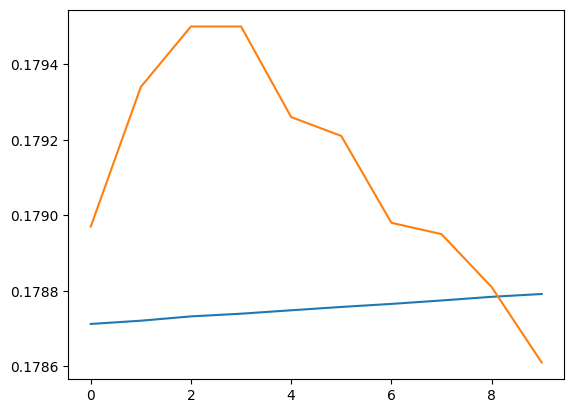

In [28]:
pd.Series(pred_paths[0]).plot()
pd.Series(train_ds.y[-2].flatten()).plot()